# import libraries

In [1]:
from constants import *
import camera_lib
import matplotlib.pyplot as plt
from ultralytics import YOLO
import clip
import torch
import cv2
from PIL import Image
import math
from bonus.gpt import get_destinaiton
import RobotArm

# test camera

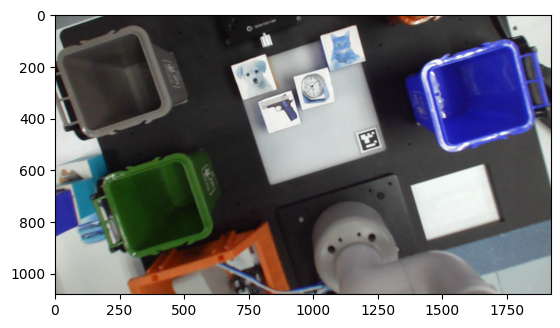

In [2]:
cam = camera_lib.Camera(0)
img = cam.capture1920x1080()
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

# test cut algorithm

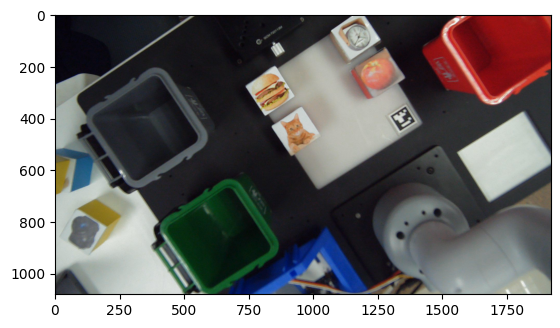

In [88]:
img = cam.capture1920x1080()
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

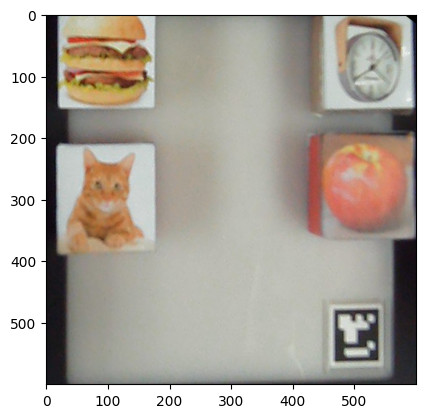

In [89]:
# img = cam.capture1920x1080()
img_cut = camera_lib.cut_image(img)
plt.figure()
plt.imshow(img_cut)
plt.show()

# prepare pretrained models

## CLIP

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


## YOLO

In [9]:
yolo = YOLO("../yolov8m-oiv7.pt")

# test image segment


0: 640x640 1 Apple, 1 Auto part, 3 Baked goodss, 1 Cat, 1 Door handle, 2 Fast foods, 1 Hamburger, 1 Ipod, 1 Picture frame, 1 Whiteboard, 551.3ms
Speed: 7.9ms preprocess, 551.3ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict10
tensor([ 96., 233.,  17., 186.,  10., 278., 165.,  13., 186., 585.,  17., 386.,  17.]) tensor([0.8517, 0.3155, 0.2621, 0.2454, 0.2089, 0.1422, 0.0192, 0.0149, 0.0139, 0.0131, 0.0131, 0.0106, 0.0104]) tensor([[ 90.5717, 303.7501, 140.2800, 172.2482],
        [ 97.3839,  74.9139, 154.8782, 149.8278],
        [ 97.2979,  75.0296, 154.8083, 149.9655],
        [ 97.4504,  74.9871, 155.0742, 149.9743],
        [516.2034, 280.8535, 142.0552, 147.3452],
        [513.9263,  82.8962, 172.0000, 165.5394],
        [525.1813,  73.5265, 112.6720, 144.1762],
        [527.0104,  79.6794,  98.5641, 127.1880],
        [ 97.8691,  95.4399, 150.9939, 106.0455],
        [300.9112, 299.6396, 598.1776, 598.3141],
        [ 94.7988

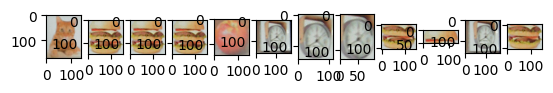

In [90]:
cutted = Image.fromarray(img_cut)
results = yolo(cutted,save=True, conf=0.01)

cutted_np = np.array(cutted)
tmp_box = []
for r in results:
    box=r.boxes
    cls=box.cls
    conf=box.conf
    xywh=box.xywh
    print(cls,conf,xywh)
    # 边界框坐标

    img_list=[]
    for i in range(0,len(box)): 
        [x, y, w, h] = xywh[i]  # 替换为实际的边界框坐标
        x=math.floor(x)
        y=math.floor(y)
        w=math.floor(w)
        h=math.floor(h)
        # 创建分割图像的掩膜
        if y > 400:
            continue
        if w > 200 or h > 200:
            continue
        if w < 50 or h < 50:
            continue
        tmp_box.append(xywh[i])
        # 分割部分的图像
        segmented_image = Image.fromarray(cutted_np[y-h//2:y+h//2, x-w//2:x+w//2])
        img_list.append(segmented_image)

original_images = img_list
plt.figure()
for id, img in enumerate(original_images):
    plt.subplot(1, len(original_images), id+1)
    plt.imshow(img)
plt.show()

# get similarities via CLIP

In [91]:
images = []

query = f"{input()}"

texts = [].append(query)

for img in original_images:
    images.append(preprocess(img))

image_input = torch.tensor(np.stack(images))
text_token = clip.tokenize(query)
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_token).float()

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

[[    0.22136     0.27347     0.27265     0.27347     0.24076     0.22626       0.222     0.22816     0.25876     0.21812     0.22546     0.25612]]


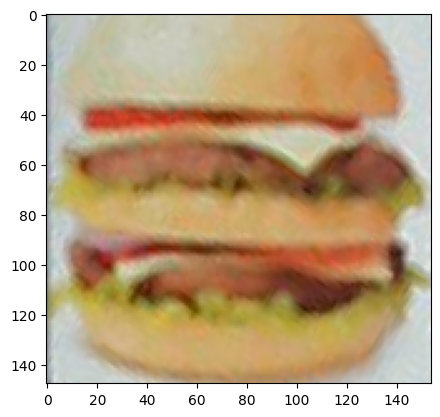

tensor([97.3839, 74.9139])


In [92]:
print(similarity)
best = np.argmax(similarity)
plt.figure()
plt.imshow(original_images[best])
plt.show()
xy = tmp_box[best]
xy = xy[:2]
print(xy)

# Robot Arm

In [85]:
need_bonus = False

In [78]:
query = "select the blackest object to the red bin"

In [100]:
if need_bonus:
    prompt = f"If left front bin is gray, left back bin is green, right front bin is blue, right back bin is red, {query}."
    dest = get_destinaiton(prompt)
    print(dest)
    if dest == "left front":
        binn = 0
    elif dest == "left back":
        binn = 1
    elif dest == "right front":
        binn = 2
    else:
        binn = 3
    RobotArm.move(xy[0], xy[1], binn)
else:
    RobotArm.move(xy[0], xy[1], 2)